In [ ]:
# Vatsal's Code

This notebook shows you how to build a model for predicting degradation at various locations along RNA sequence. 
* We will first pre-process and tokenize the sequence, secondary structure and loop type. 
* Then, we will use all the information to train a model on degradations recorded by the researchers from OpenVaccine. 
* Finally, we run our model on the public test set (shorter sequences) and the private test set (longer sequences), and submit the predictions.


In [1]:
# %%capture
# !pip install forgi
# !yes Y |conda install -c bioconda viennarna

In [2]:
import json,os, math

import subprocess
# from forgi.graph import bulge_graph
# import forgi.visual.mplotlib as fvm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
import plotly.express as px
import tensorflow.keras.layers as L
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

import tensorflow_addons as tfa

from itertools import combinations_with_replacement
from sklearn.model_selection import train_test_split, KFold,  StratifiedKFold,GroupKFold
from keras.utils import plot_model
from colorama import Fore, Back, Style

## Configuration

In [3]:
###### USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 53

###### NUMBER OF FOLDS. USE 3, 5, 7,... 
n_folds=5

###### TRAIN DEBUG
debug=True

###### APPLY WINDOW FEATURES
Window_features = True

###### Number of Feature Given to Model
# cat_feature = 3  ## ( Categorical Features Only)
# num_features = 1  ## ( Numerical Features Only)

###### Model Configuration ######

model_name="GG"                ## MODEL NAME (Files will save according to this )
epochs=100              ## NUMBER OF EPOCHS MODEL TRAIN IN EACH FOLD. USE 3, 5, 7,... 
BATCH_SIZE = 32                 ## NUMBER OF BATCH_SIZE USE 16, 32, 64, 128,...
n_layers = 2                  ## Number of Layers Present in model # ex. 3 Layer of GRU Model
layers = ["GRU","GRU"]   ## Stacking sequence of GRU and LSTM (list of length == n_layers)
hidden_dim = [128, 128]    ## Hidden Dimension in Model (Default : [128,128]) (list of length == n_layers)
dropout = [0.5, 0.5]       ## 1.0 means no dropout, and 0.0 means no outputs from the layer.
sp_dropout = 0.2                ## SpatialDropout1D (Fraction of the input units to drop) [https://stackoverflow.com/a/55244985]
embed_dim = 250                  ## Output Dimention of Embedding Layer (Default : 75)
num_hidden_units = 8      ## Number of GRU units after num_input layer


###### LR Schedular ######

Cosine_Schedule = True         ## cosine_schedule Rate
Rampup_decy_lr = False           ## Rampup decy lr Schedule

## Set Seed

In [4]:
def seed_everything(seed=1234):   
    np.random.seed(seed)   
    tf.random.set_seed(seed)   
    os.environ['PYTHONHASHSEED'] = str(seed)   
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
seed_everything(SEED)

## Used Columns


In [5]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
window_columns = ['sequence','structure','predicted_loop_type']

categorical_features = ['sequence', 'structure', 'predicted_loop_type',]
#                        'predicted_loop_index']

cat_feature = len(categorical_features)
if Window_features:
    cat_feature += len(window_columns)

numerical_features = ['BPPS_Max','BPPS_nb', 'BPPS_sum',
                      'positional_entropy',
                      'stems', 'interior_loops', 'multiloops',#'hairpin loops', 'fiveprimes', 'threeprimes', 
                      'A_percent', 'G_percent','C_percent', 'U_percent', 
                      'U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U', 
#                       'E', 'S', 'H', 'B', 'X', 'I', 'M', 
                      'pair_map', 'pair_distance', ]
    

num_features = len(numerical_features)  ## ( Numerical Features Only)

feature_cols = categorical_features + numerical_features
pred_col_names = ["pred_"+c_name for c_name in target_cols]

target_eval_col = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
pred_eval_col = ["pred_"+c_name for c_name in target_eval_col]

## Load and preprocess data

In [6]:
data_dir = '/kaggle/input/stanford-covid-vaccine/'
fearure_data_path = '../input/openvaccine/'

# train  = pd.read_csv(fearure_data_path+'train.csv')
# test = pd.read_csv(fearure_data_path+'test.csv')

train  = pd.read_json(fearure_data_path+'train.json')
test = pd.read_json(fearure_data_path+'test.json')

# train_j = pd.read_json(data_dir + 'train.json', lines=True)
# test_j = pd.read_json(data_dir + 'test.json', lines=True)
sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')

In [7]:
train[target_cols] = train[target_cols].applymap(lambda x: x[1:-1].split(", "))

In [8]:
# train = train[train['SN_filter'] == 1]
train = train[train['signal_to_noise'] >= 0.5]

In [9]:
def pair_feature(row):
    arr = list(row)
    its = [iter(['_']+arr[:]) ,iter(arr[1:]+['_'])]
    list_touple = list(zip(*its))
    return list(map("".join,list_touple))

In [10]:
def preprocess_categorical_inputs(df, cols=categorical_features,Window_features=Window_features):
    
    if Window_features:
        for c in window_columns:
            df["pair_"+c] = df[c].apply(pair_feature)
            cols.append("pair_"+c)
    cols = list(set(cols))
    
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [11]:
def preprocess_numerical_inputs(df, cols=numerical_features):
    
    return np.transpose(
        np.array(
            df[cols].values.tolist()
        ),
        (0, 2, 1)
    )

In [12]:
# We will use this dictionary to map each character to an integer
# so that it can be used as an input in keras
# ().ACGUBEHIMSXshftim0123456789[]{}'_,
token_list = list("().ACGUESHBXIM")
if Window_features:
    comb = combinations_with_replacement(list('_().ACGUESHBXIM'*2), 2) 
    token_list += list(set(list(map("".join,comb))))

token2int = {x:i for i, x in enumerate(list(set(token_list)))}
print("token_list Size :",len(token_list))
    
train_inputs_all_cat = preprocess_categorical_inputs(train,cols=categorical_features)
train_inputs_all_num = preprocess_numerical_inputs(train,cols=numerical_features)
train_labels_all = np.array(train[target_cols].values.tolist(),dtype =np.float32).transpose((0, 2, 1))

print("Train categorical Features Shape : ",train_inputs_all_cat.shape)
print("Train numerical Features Shape : ",train_inputs_all_num.shape)
print("Train labels Shape : ",train_labels_all.shape)

token_list Size : 239
Train categorical Features Shape :  (3718, 107, 6)
Train numerical Features Shape :  (3718, 107, 19)
Train labels Shape :  (3718, 68, 5)


## Reduce Train Data

In [13]:
# train_inputs_all_cat = train_inputs_all_cat[:,:68,:]
# train_inputs_all_num = train_inputs_all_num[:,:68,:]
# train_labels_all = train_labels_all[:,:68,:]

# print("Train categorical Features Shape : ",train_inputs_all_cat.shape)
# print("Train numerical Features Shape : ",train_inputs_all_num.shape)
# print("Train labels Shape : ",train_labels_all.shape)

#### Public and private sets have different sequence lengths, so we will preprocess them separately and load models of different tensor shapes.

In [14]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")
print("public_df : ",public_df.shape)
print("private_df : ",private_df.shape)

public_inputs_cat = preprocess_categorical_inputs(public_df)
private_inputs_cat = preprocess_categorical_inputs(private_df)

public_inputs_num = preprocess_numerical_inputs(public_df,cols=numerical_features)
private_inputs_num = preprocess_numerical_inputs(private_df,cols=numerical_features)

print("Public categorical Features Shape : ",public_inputs_cat.shape)
print("Public numerical Features Shape : ",public_inputs_num.shape)

print("Private categorical Features Shape : ",private_inputs_cat.shape)
print("Private numerical Features Shape : ",private_inputs_num.shape)

public_df :  (1040, 38)
private_df :  (6850, 38)
Public categorical Features Shape :  (1040, 107, 6)
Public numerical Features Shape :  (1040, 107, 19)
Private categorical Features Shape :  (6850, 130, 6)
Private numerical Features Shape :  (6850, 130, 19)


## loss Function

In [15]:
### Custom Loss Function for ['reactivity','deg_Mg_pH10','deg_Mg_50C'] target Columns

# def rmse(y_actual, y_pred):
#     mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
#     return K.sqrt(mse)

# def MCRMSE(y_actual, y_pred, num_scored=3):
#     score = 0
#     for i in range(num_scored):
#         score += rmse(y_actual[:,:, i], y_pred[:,:, i]) / num_scored
#     return score

def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true[:,:,:3] - y_pred[:,:,:3]), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

## Learning Rate Schedulars
### Rampup decy lr Schedule

In [16]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.00001
    lr_max     = 0.004
    lr_min     = 0.00005
    lr_ramp_ep = 45
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

### Cosine schedule with warmup

In [17]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=3.5):
    """
    Modified version of the get_cosine_schedule_with_warmup from huggingface.
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

## Different Layers

In [18]:
def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

In [19]:
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(
        L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal')
    )

## Model Building

In [20]:
# def build_model(embed_size, 
#                 seq_len = 107, 
#                 pred_len = 68, 
#                 dropout = dropout, 
#                 sp_dropout = sp_dropout, 
#                 num_features = num_features,
#                 num_hidden_units = num_hidden_units,
#                 embed_dim = embed_dim,
#                 layers = layers, 
#                 hidden_dim = hidden_dim, 
#                 n_layers = n_layers,
#                 cat_feature = cat_feature):
    
#     inputs = L.Input(shape=(seq_len, cat_feature),name='category_input')
#     embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
#     reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
#     reshaped_conv = tf.keras.layers.Conv1D(filters=512, kernel_size=3,strides=1, padding='same', activation='elu')(reshaped)
    
#     numerical_input = L.Input(shape=(seq_len, num_features), name='numeric_input')
#     n_Dense_1 = L.Dense(64)(numerical_input)
#     n_Dense_2 = L.Dense(128)(n_Dense_1)
#     numerical_conv = tf.keras.layers.Conv1D(filters=256, kernel_size=4,strides=1, padding='same', activation='elu')(n_Dense_2)
    
#     hidden = L.concatenate([reshaped_conv, numerical_conv])
#     hidden = L.SpatialDropout1D(sp_dropout)(hidden)
    
#     for x in range(n_layers):
#         if layers[x] == "GRU":
#             hidden = gru_layer(hidden_dim[x], dropout[x])(hidden)
#         else:
#             hidden = lstm_layer(hidden_dim[x], dropout[x])(hidden)
            
#     # Since we are only making predictions on the first part of each sequence, 
#     # we have to truncate it
#     truncated = hidden[:, :pred_len]
    
#     out = L.Dense(5)(truncated)
    
#     model = tf.keras.Model(inputs=[inputs] + [numerical_input], outputs=out)
    
#     adam = tf.optimizers.Adam()
#     radam = tfa.optimizers.RectifiedAdam()
#     lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
#     ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
#     model.compile(optimizer=radam, loss=MCRMSE)
    
#     return model

In [21]:
def build_model(embed_size, 
                seq_len = 107, 
                pred_len = 68, 
                dropout = dropout, 
                sp_dropout = sp_dropout, 
                num_features = num_features,
                num_hidden_units = num_hidden_units,
                embed_dim = embed_dim,
                layers = layers, 
                hidden_dim = hidden_dim, 
                n_layers = n_layers,
                cat_feature = cat_feature):
    
    inputs = L.Input(shape=(seq_len, cat_feature),name='category_input')
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    reshaped = L.SpatialDropout1D(sp_dropout)(reshaped)
    reshaped_conv = tf.keras.layers.Conv1D(filters=512, kernel_size=3,strides=1, padding='same', activation='elu')(reshaped)
    
    numerical_input = L.Input(shape=(seq_len, num_features), name='numeric_input')
#     n_Dense_1 = L.Dense(64)(numerical_input)
#     n_Dense_2 = L.Dense(128)(n_Dense_1)
#     numerical_conv = tf.keras.layers.Conv1D(filters=256, kernel_size=4,strides=1, padding='same', activation='elu')(n_Dense_2)
    
    hidden = L.concatenate([reshaped_conv, numerical_input])
    hidden_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=4,strides=1, padding='same', activation='elu')(hidden)
    hidden = gru_layer(128, 0.5)(hidden_1)
    hidden = L.concatenate([hidden, hidden_1])
#     hidden = L.SpatialDropout1D(sp_dropout)(hidden)
    
    for x in range(n_layers):
        if layers[x] == "GRU":
            hidden = gru_layer(hidden_dim[x], dropout[x])(hidden)
        else:
            hidden = lstm_layer(hidden_dim[x], dropout[x])(hidden)
        
        hidden = L.concatenate([hidden, hidden_1])
            
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    
    out = L.Dense(5)(truncated)
    
    model = tf.keras.Model(inputs=[inputs] + [numerical_input], outputs=out)
    
    adam = tf.optimizers.Adam()
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    model.compile(optimizer=radam, loss=MCRMSE)
    
    return model

## Build and train model

We will train a bi-directional GRU model. It has three layer and has dropout. To learn more about RNNs, LSTM and GRU, please see [this blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

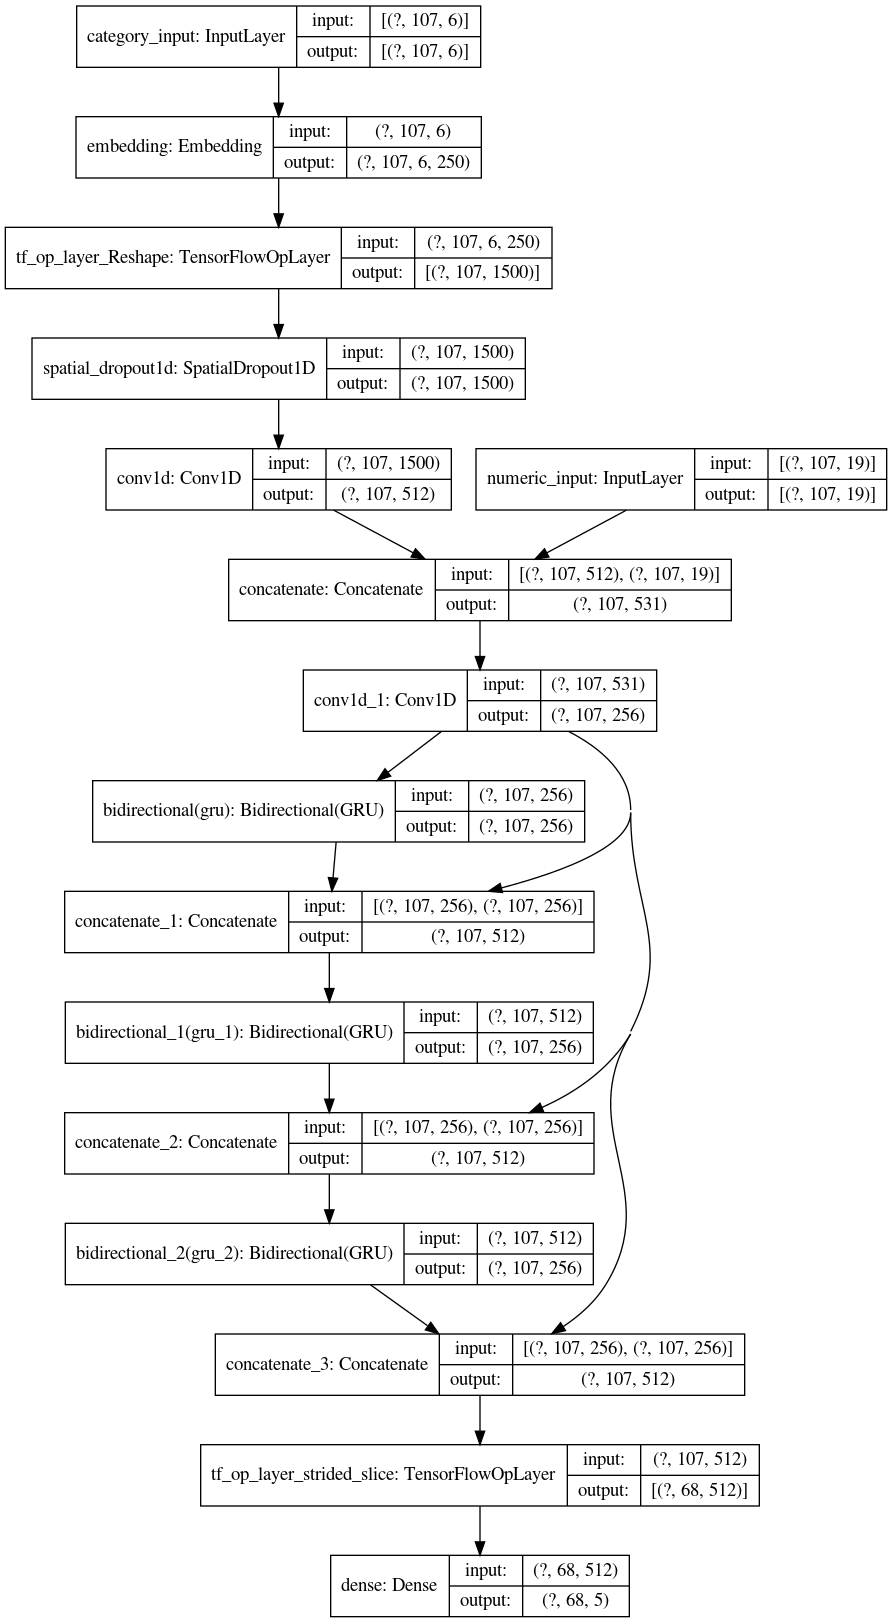

In [22]:
model = build_model(embed_size=len(token_list))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Add Augmentation Data

## stratify_group Based on structure and SN_Filter


#############################################
###  Fold :  1
#############################################

Augmented data Present in Val Data :  302
Augmented data Present in Train Data :  1204
Data Lekage :  0
number of Train Data points :  2974
number of val_data Data points :  442
number of unique Structure in Train data :  2215
number of unique Structure in val data :  319 [33 14 13 13  9]
Train SN_Filter == 1 :  2112
val_data SN_Filter == 1 :  327
Train SN_Filter == 0 :  862
val_data SN_Filter == 0 :  115
Unique ID : 1770

#############################################
###  Fold :  2
#############################################

Augmented data Present in Val Data :  301
Augmented data Present in Train Data :  1205
Data Lekage :  0
number of Train Data points :  2974
number of val_data Data points :  443
number of unique Structure in Train data :  2202
number of unique Structure in val data :  333 [49 13 11  6  6]
Train SN_Filter == 1 :  2110
val_data SN_Filter == 1 :  316
Train 

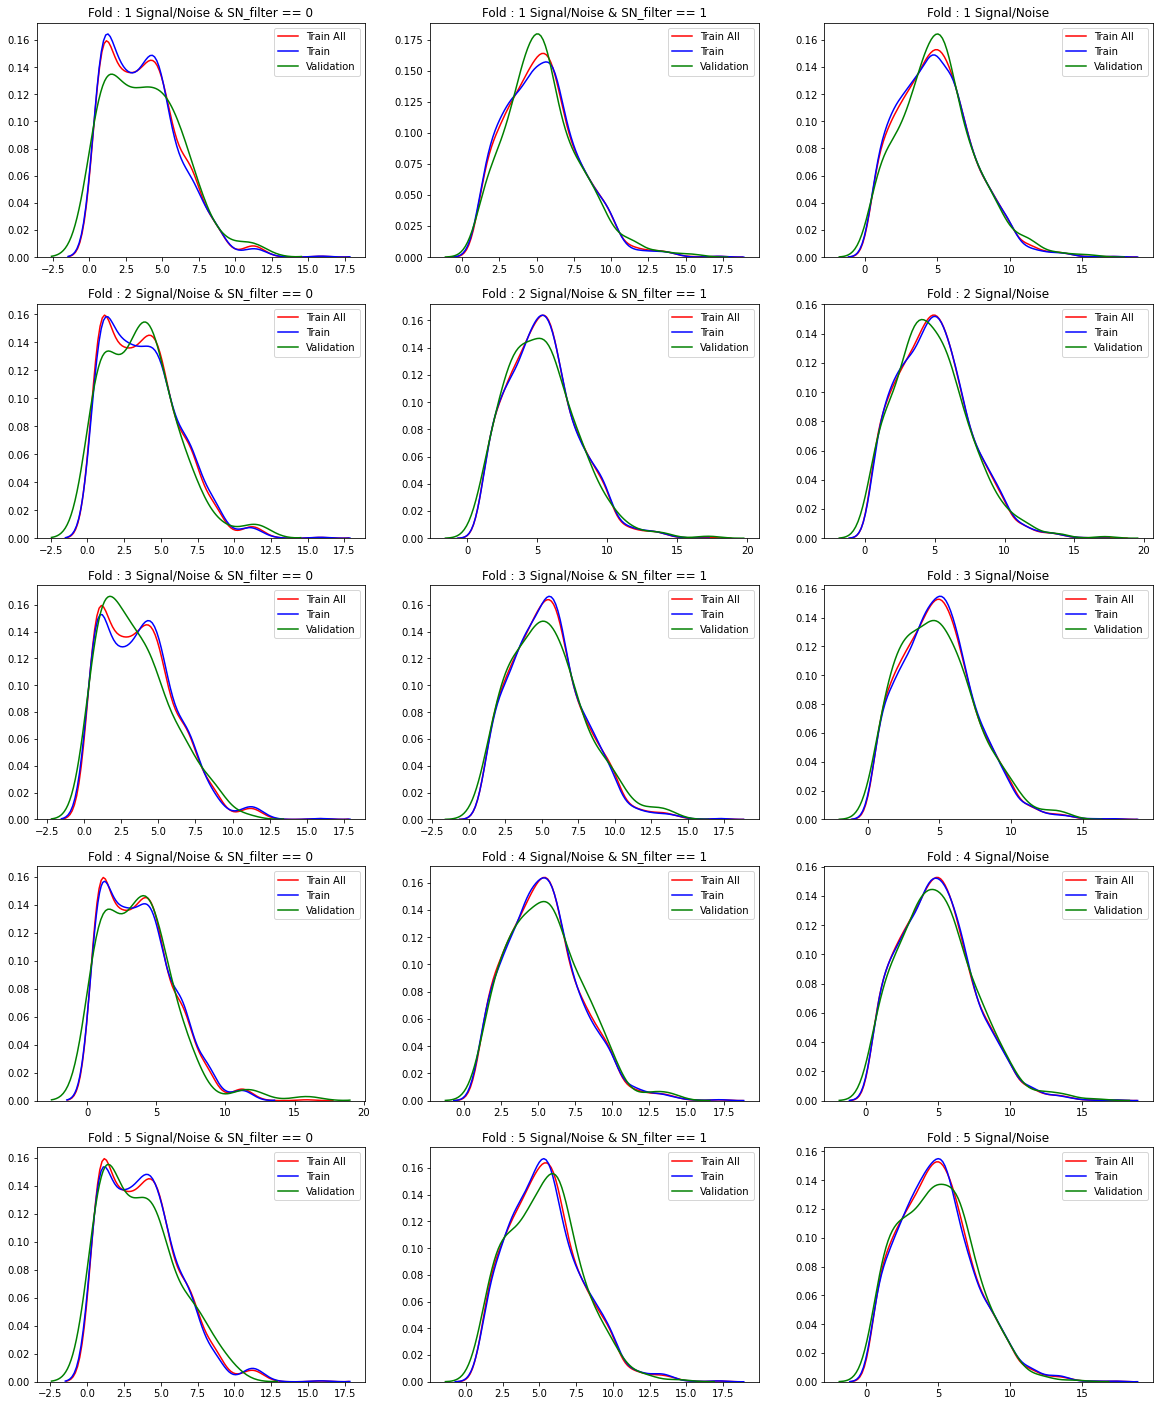

In [23]:
def get_stratify_group(row):
    snf = row['SN_filter']
    snr = row['signal_to_noise']
    cnt = row['cnt']
    id_ = row['id']
    structure = row['structure']
    if snf == 0:
        if snr<0:
            snr_c = 0
        elif 0<= snr < 2:
            snr_c = 1
        elif 2<= snr < 4:
            snr_c = 2
        elif 4<= snr < 5.5:
            snr_c = 3
        elif 5.5<= snr < 10:
            snr_c = 4
        elif snr >= 10:
            snr_c = 5
            
    else: # snf == 1
        if snr<0:
            snr_c = 6
        elif 0<= snr < 1:
            snr_c = 7
        elif 1<= snr < 2:
            snr_c = 8
        elif 2<= snr < 3:
            snr_c = 9
        elif 3<= snr < 4:
            snr_c = 10
        elif 4<= snr < 5:
            snr_c = 11
        elif 5<= snr < 6:
            snr_c = 12
        elif 6<= snr < 7:
            snr_c = 13
        elif 7<= snr < 8:
            snr_c = 14
        elif 8<= snr < 9:
            snr_c = 15
        elif 9<= snr < 10:
            snr_c = 15
        elif snr >= 10:
            snr_c = 16
        
    return '{}_{}'.format(id_,snr_c)

train['stratify_group'] = train.apply(get_stratify_group, axis=1)
train['stratify_group'] = train['stratify_group'].astype('category').cat.codes

skf = StratifiedKFold(n_folds, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=n_folds)
fig, ax = plt.subplots(n_folds,3,figsize=(20,5*n_folds))

for Fold, (train_index, val_index) in enumerate(gkf.split(train_inputs_all_cat, groups=train['stratify_group'])):
    print(Fore.YELLOW);print('#'*45);print("###  Fold : ", str(Fold+1));print('#'*45);print(Style.RESET_ALL)
    
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]
    print("Augmented data Present in Val Data : ",len(val_data[val_data['cnt'] != 1]))
    print("Augmented data Present in Train Data : ",len(train_data[train_data['cnt'] != 1]))
    val_data = val_data[val_data['cnt'] == 1]
    print("Data Lekage : ",len(val_data[val_data['id'].isin(train_data['id'])]))
#     print(train_data['stratify_group'].unique(),val_data['stratify_group'].unique())
    
    print("number of Train Data points : ",len(train_data))
    print("number of val_data Data points : ",len(val_data))
    print("number of unique Structure in Train data : ", len(train_data.structure.unique()))
    print("number of unique Structure in val data : ",len(val_data.structure.unique()), val_data.structure.value_counts()[:5].values)
    
    print("Train SN_Filter == 1 : ", len(train_data[train_data['SN_filter']==1]))
    print("val_data SN_Filter == 1 : ", len(val_data[val_data['SN_filter']==1]))
    print("Train SN_Filter == 0 : ", len(train_data[train_data['SN_filter']==0]))
    print("val_data SN_Filter == 0 : ", len(val_data[val_data['SN_filter']==0]))
    
    print("Unique ID :",len(train_data.id.unique()))
    sns.kdeplot(train[train['SN_filter']==0]['signal_to_noise'],ax=ax[Fold][0],color="Red",label='Train All')
    sns.kdeplot(train_data[train_data['SN_filter']==0]['signal_to_noise'],ax=ax[Fold][0],color="Blue",label='Train')
    sns.kdeplot(val_data[val_data['SN_filter']==0]['signal_to_noise'],ax=ax[Fold][0],color="Green",label='Validation')            
    ax[Fold][0].set_title(f'Fold : {Fold+1} Signal/Noise & SN_filter == 0')
    
    sns.kdeplot(train[train['SN_filter']==1]['signal_to_noise'],ax=ax[Fold][1],color="Red",label='Train All')
    sns.kdeplot(train_data[train_data['SN_filter']==1]['signal_to_noise'],ax=ax[Fold][1],color="Blue",label='Train')
    sns.kdeplot(val_data[val_data['SN_filter']==1]['signal_to_noise'],ax=ax[Fold][1],color="Green",label='Validation')            
    ax[Fold][1].set_title(f'Fold : {Fold+1} Signal/Noise & SN_filter == 1')
    
    sns.kdeplot(train['signal_to_noise'],ax=ax[Fold][2],color="Red",label='Train All')
    sns.kdeplot(train_data['signal_to_noise'],ax=ax[Fold][2],color="Blue",label='Train')
    sns.kdeplot(val_data['signal_to_noise'],ax=ax[Fold][2],color="Green",label='Validation')            
    ax[Fold][2].set_title(f'Fold : {Fold+1} Signal/Noise')
            
plt.show()



#############################################
###  Fold :  1
#############################################

|| Batch_size: 32 
|| n_layers: 2 
|| embed_dim: 250
|| cat_feature: 6 
|| num_features: 19
|| layers : ['GRU', 'GRU'] 
|| hidden_dim: [128, 128] 
|| dropout: [0.5, 0.5] 
|| sp_dropout: 0.2
|| number Augmented data Present in Val Data :  302
|| number Augmented data Present in Train Data :  1204
|| Data Lekage :  0
Epoch 1/100
93/93 [==============================] - 9s 95ms/step - loss: 0.6279 - val_loss: 0.6366
Epoch 2/100
93/93 [==============================] - 7s 70ms/step - loss: 0.4501 - val_loss: 0.4061
Epoch 3/100
93/93 [==============================] - 7s 72ms/step - loss: 0.3717 - val_loss: 0.3577
Epoch 4/100
93/93 [==============================] - 7s 71ms/step - loss: 0.3460 - val_loss: 0.3414
Epoch 5/100
93/93 [==============================] - 7s 70ms/step - loss: 0.3366 - val_loss: 0.3358
Epoch 6/100
93/93 [==============================] - 7s 71ms/step - loss: 

Epoch 78/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1729 - val_loss: 0.2219
Epoch 79/100
93/93 [==============================] - 7s 70ms/step - loss: 0.1732 - val_loss: 0.2217
Epoch 80/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1734 - val_loss: 0.2216
Epoch 81/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1739 - val_loss: 0.2227
Epoch 82/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1747 - val_loss: 0.2225
Epoch 83/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1759 - val_loss: 0.2235
Epoch 84/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1773 - val_loss: 0.2248
Epoch 85/100
93/93 [==============================] - 7s 70ms/step - loss: 0.1794 - val_loss: 0.2298
Epoch 86/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1806 - val_loss: 0.2263
Epoch 87/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1824 - val_los

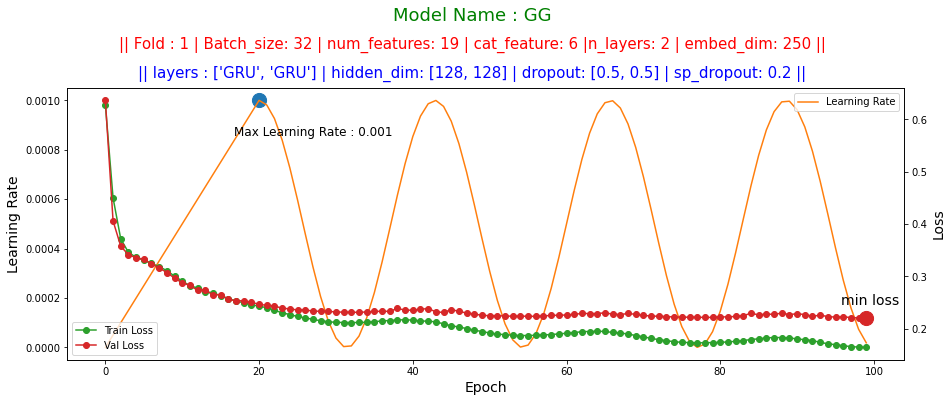


#############################################
###  Fold :  2
#############################################

|| Batch_size: 32 
|| n_layers: 2 
|| embed_dim: 250
|| cat_feature: 6 
|| num_features: 19
|| layers : ['GRU', 'GRU'] 
|| hidden_dim: [128, 128] 
|| dropout: [0.5, 0.5] 
|| sp_dropout: 0.2
|| number Augmented data Present in Val Data :  301
|| number Augmented data Present in Train Data :  1205
|| Data Lekage :  0
Epoch 1/100
93/93 [==============================] - 8s 88ms/step - loss: 0.6235 - val_loss: 0.6195
Epoch 2/100
93/93 [==============================] - 7s 70ms/step - loss: 0.4504 - val_loss: 0.3994
Epoch 3/100
93/93 [==============================] - 7s 72ms/step - loss: 0.3697 - val_loss: 0.3514
Epoch 4/100
93/93 [==============================] - 6s 70ms/step - loss: 0.3459 - val_loss: 0.3387
Epoch 5/100
93/93 [==============================] - 7s 71ms/step - loss: 0.3374 - val_loss: 0.3332
Epoch 6/100
93/93 [==============================] - 6s 69ms/step - loss: 

Epoch 78/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1723 - val_loss: 0.2220
Epoch 79/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1724 - val_loss: 0.2218
Epoch 80/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1727 - val_loss: 0.2216
Epoch 81/100
93/93 [==============================] - 6s 69ms/step - loss: 0.1729 - val_loss: 0.2225
Epoch 82/100
93/93 [==============================] - 6s 69ms/step - loss: 0.1740 - val_loss: 0.2224
Epoch 83/100
93/93 [==============================] - 7s 70ms/step - loss: 0.1751 - val_loss: 0.2233
Epoch 84/100
93/93 [==============================] - 6s 68ms/step - loss: 0.1765 - val_loss: 0.2243
Epoch 85/100
93/93 [==============================] - 6s 69ms/step - loss: 0.1783 - val_loss: 0.2244
Epoch 86/100
93/93 [==============================] - 6s 69ms/step - loss: 0.1801 - val_loss: 0.2249
Epoch 87/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1817 - val_los

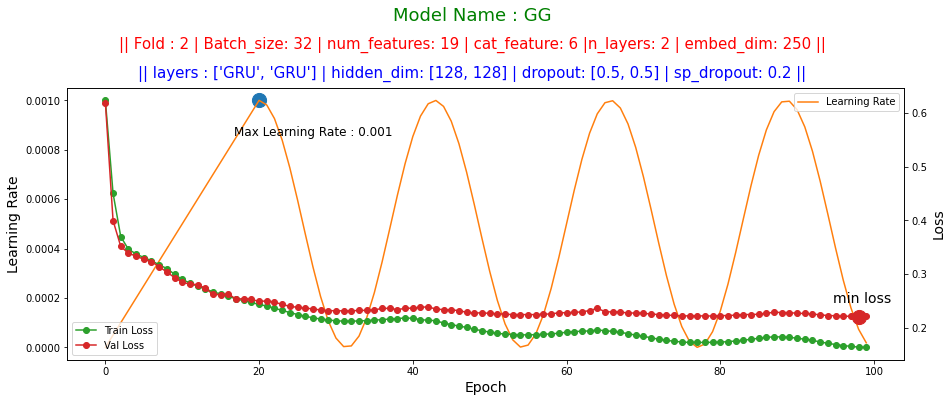


#############################################
###  Fold :  3
#############################################

|| Batch_size: 32 
|| n_layers: 2 
|| embed_dim: 250
|| cat_feature: 6 
|| num_features: 19
|| layers : ['GRU', 'GRU'] 
|| hidden_dim: [128, 128] 
|| dropout: [0.5, 0.5] 
|| sp_dropout: 0.2
|| number Augmented data Present in Val Data :  301
|| number Augmented data Present in Train Data :  1205
|| Data Lekage :  0
Epoch 1/100
93/93 [==============================] - 8s 89ms/step - loss: 0.6981 - val_loss: 0.6976
Epoch 2/100
93/93 [==============================] - 7s 72ms/step - loss: 0.4715 - val_loss: 0.4076
Epoch 3/100
93/93 [==============================] - 7s 73ms/step - loss: 0.3745 - val_loss: 0.3548
Epoch 4/100
93/93 [==============================] - 7s 71ms/step - loss: 0.3466 - val_loss: 0.3393
Epoch 5/100
93/93 [==============================] - 7s 73ms/step - loss: 0.3366 - val_loss: 0.3329
Epoch 6/100
93/93 [==============================] - 7s 71ms/step - loss: 

Epoch 78/100
93/93 [==============================] - 7s 75ms/step - loss: 0.1714 - val_loss: 0.2242
Epoch 79/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1713 - val_loss: 0.2241
Epoch 80/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1716 - val_loss: 0.2237
Epoch 81/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1721 - val_loss: 0.2242
Epoch 82/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1730 - val_loss: 0.2250
Epoch 83/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1740 - val_loss: 0.2266
Epoch 84/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1758 - val_loss: 0.2290
Epoch 85/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1775 - val_loss: 0.2275
Epoch 86/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1786 - val_loss: 0.2310
Epoch 87/100
93/93 [==============================] - 7s 75ms/step - loss: 0.1803 - val_los

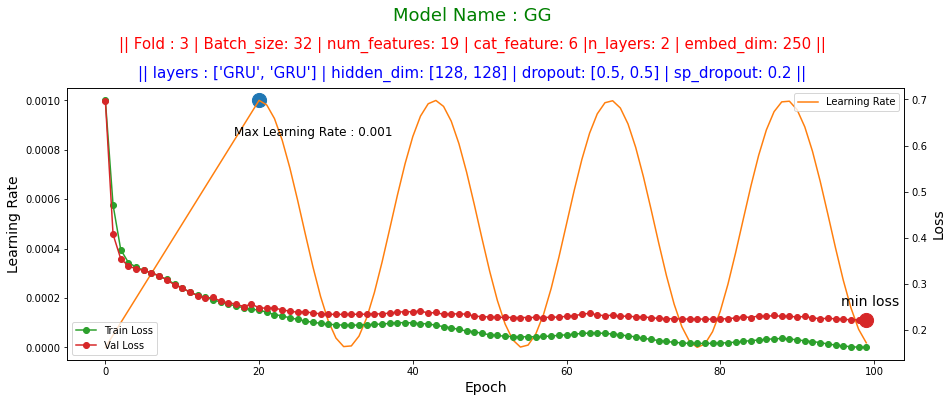


#############################################
###  Fold :  4
#############################################

|| Batch_size: 32 
|| n_layers: 2 
|| embed_dim: 250
|| cat_feature: 6 
|| num_features: 19
|| layers : ['GRU', 'GRU'] 
|| hidden_dim: [128, 128] 
|| dropout: [0.5, 0.5] 
|| sp_dropout: 0.2
|| number Augmented data Present in Val Data :  301
|| number Augmented data Present in Train Data :  1205
|| Data Lekage :  0
Epoch 1/100
93/93 [==============================] - 8s 91ms/step - loss: 0.5811 - val_loss: 0.5725
Epoch 2/100
93/93 [==============================] - 7s 71ms/step - loss: 0.4436 - val_loss: 0.3954
Epoch 3/100
93/93 [==============================] - 7s 74ms/step - loss: 0.3709 - val_loss: 0.3473
Epoch 4/100
93/93 [==============================] - 7s 72ms/step - loss: 0.3468 - val_loss: 0.3353
Epoch 5/100
93/93 [==============================] - 7s 71ms/step - loss: 0.3381 - val_loss: 0.3301
Epoch 6/100
93/93 [==============================] - 7s 75ms/step - loss: 

Epoch 78/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1725 - val_loss: 0.2162
Epoch 79/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1729 - val_loss: 0.2162
Epoch 80/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1731 - val_loss: 0.2166
Epoch 81/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1736 - val_loss: 0.2166
Epoch 82/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1744 - val_loss: 0.2170
Epoch 83/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1757 - val_loss: 0.2164
Epoch 84/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1771 - val_loss: 0.2203
Epoch 85/100
93/93 [==============================] - 7s 76ms/step - loss: 0.1787 - val_loss: 0.2204
Epoch 86/100
93/93 [==============================] - 7s 75ms/step - loss: 0.1805 - val_loss: 0.2217
Epoch 87/100
93/93 [==============================] - 7s 71ms/step - loss: 0.1824 - val_los

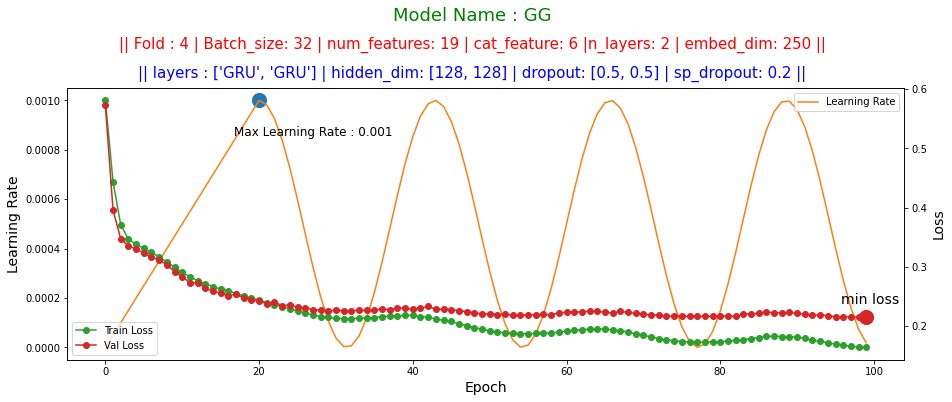


#############################################
###  Fold :  5
#############################################

|| Batch_size: 32 
|| n_layers: 2 
|| embed_dim: 250
|| cat_feature: 6 
|| num_features: 19
|| layers : ['GRU', 'GRU'] 
|| hidden_dim: [128, 128] 
|| dropout: [0.5, 0.5] 
|| sp_dropout: 0.2
|| number Augmented data Present in Val Data :  301
|| number Augmented data Present in Train Data :  1205
|| Data Lekage :  0
Epoch 1/100
93/93 [==============================] - 8s 89ms/step - loss: 0.6790 - val_loss: 0.6815
Epoch 2/100
93/93 [==============================] - 7s 73ms/step - loss: 0.4603 - val_loss: 0.4060
Epoch 3/100
93/93 [==============================] - 7s 71ms/step - loss: 0.3703 - val_loss: 0.3578
Epoch 4/100
93/93 [==============================] - 7s 74ms/step - loss: 0.3450 - val_loss: 0.3443
Epoch 5/100
93/93 [==============================] - 7s 74ms/step - loss: 0.3357 - val_loss: 0.3398
Epoch 6/100
93/93 [==============================] - 7s 71ms/step - loss: 

Epoch 78/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1726 - val_loss: 0.2235
Epoch 79/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1726 - val_loss: 0.2235
Epoch 80/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1731 - val_loss: 0.2230
Epoch 81/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1734 - val_loss: 0.2239
Epoch 82/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1742 - val_loss: 0.2254
Epoch 83/100
93/93 [==============================] - 7s 74ms/step - loss: 0.1759 - val_loss: 0.2251
Epoch 84/100
93/93 [==============================] - 7s 76ms/step - loss: 0.1767 - val_loss: 0.2270
Epoch 85/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1792 - val_loss: 0.2279
Epoch 86/100
93/93 [==============================] - 7s 72ms/step - loss: 0.1810 - val_loss: 0.2262
Epoch 87/100
93/93 [==============================] - 7s 73ms/step - loss: 0.1816 - val_los

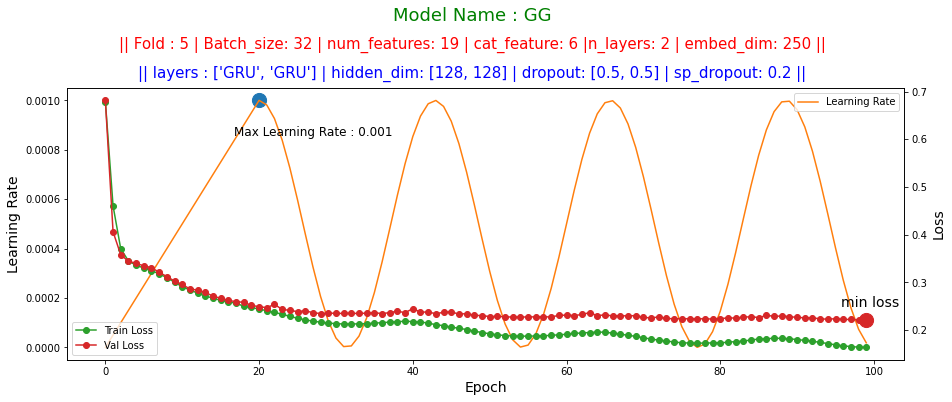

In [24]:
submission = pd.DataFrame(index=sample_sub.index, columns=target_cols).fillna(0) # test dataframe with 0 values

val_losses = []
historys = []
oof_preds_all = []
stacking_pred_all = []

kf = KFold(n_folds, shuffle=True, random_state=SEED)
skf = StratifiedKFold(n_folds, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=n_folds)

for Fold, (train_index, val_index) in enumerate(gkf.split(train_inputs_all_cat, groups=train['stratify_group'])):
    print(Fore.YELLOW);print('#'*45);print("###  Fold : ", str(Fold+1));print('#'*45);print(Style.RESET_ALL)
    print(f"|| Batch_size: {BATCH_SIZE} \n|| n_layers: {n_layers} \n|| embed_dim: {embed_dim}")
    print(f"|| cat_feature: {cat_feature} \n|| num_features: {num_features}")
    print(f"|| layers : {layers} \n|| hidden_dim: {hidden_dim} \n|| dropout: {dropout} \n|| sp_dropout: {sp_dropout}")
    
    
    train_data = train.iloc[train_index]
    val_data = train.iloc[val_index]
    
    print("|| number Augmented data Present in Val Data : ",len(val_data[val_data['cnt'] != 1]))
    print("|| number Augmented data Present in Train Data : ",len(train_data[train_data['cnt'] != 1]))
    print("|| Data Lekage : ",len(val_data[val_data['id'].isin(train_data['id'])]))
    
    val_data = val_data[val_data['cnt'] == 1]
    model_train = build_model(embed_size=len(token_list))
    model_short = build_model(embed_size=len(token_list),seq_len=107, pred_len=107)
    model_long = build_model(embed_size=len(token_list),seq_len=130, pred_len=130)

    train_inputs_cat = preprocess_categorical_inputs(train_data,cols=categorical_features)
    train_inputs_num = preprocess_numerical_inputs(train_data,cols=numerical_features)
    train_labels = np.array(train_data[target_cols].values.tolist(),dtype =np.float32).transpose((0, 2, 1))
    
    val_inputs_cat = preprocess_categorical_inputs(val_data,cols=categorical_features)
    val_inputs_num = preprocess_numerical_inputs(val_data,cols=numerical_features)
    val_labels = np.array(val_data[target_cols].values.tolist(),dtype =np.float32).transpose((0, 2, 1))
    
#     train_inputs_cat, train_labels = train_inputs_all_cat[train_index], train_labels_all[train_index]
#     val_inputs_cat, val_labels = train_inputs_all_cat[val_index], train_labels_all[val_index]
#     train_inputs_num, val_inputs_num = train_inputs_all_num[train_index],train_inputs_all_num[val_index]
    
    # csv_logger
    csv_logger = tf.keras.callbacks.CSVLogger(f'Fold_{Fold}_log.csv', separator=',', append=False)
    
    # SAVE BEST MODEL EACH FOLD
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}_Fold_{Fold}.h5', 
                                                    monitor='val_loss', 
                                                    verbose=0, 
                                                    mode='min', 
                                                    save_freq='epoch')
    
    if Cosine_Schedule:
        #cosine Callback
        lr_schedule= get_cosine_schedule_with_warmup(lr=0.001, num_warmup_steps=20, num_training_steps=epochs)
    elif Rampup_decy_lr : 
        # Rampup decy lr 
        lr_schedule = get_lr_callback(BATCH_SIZE)
    else:
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau()
        
    history = model_train.fit(
        {'numeric_input': train_inputs_num,
           'category_input': train_inputs_cat} , train_labels, 
        validation_data=({'numeric_input': val_inputs_num,
                          'category_input': val_inputs_cat}
                         ,val_labels),
        batch_size=BATCH_SIZE,
        epochs=epochs, 
        callbacks=[lr_schedule, checkpoint, csv_logger,lr_schedule],
        verbose=1 if debug else 0
    )
    
    print("Min Validation Loss : ", min(history.history['val_loss']))
    print("Min Validation Epoch : ",np.argmin( history.history['val_loss'] )+1)
    val_losses.append(min(history.history['val_loss']))
    historys.append(history)

    model_short.load_weights(f'{model_name}_Fold_{Fold}.h5')
    model_long.load_weights(f'{model_name}_Fold_{Fold}.h5')
    
    public_preds = model_short.predict({'numeric_input': public_inputs_num,
                                        'category_input': public_inputs_cat})
    
    private_preds = model_long.predict({'numeric_input': private_inputs_num,
                                        'category_input': private_inputs_cat})
    
    oof_preds = model_train.predict({'numeric_input': val_inputs_num,
                                        'category_input': val_inputs_cat})
    
    stacking_pred = model_short.predict({'numeric_input': val_inputs_num,
                                        'category_input': val_inputs_cat})
    
    preds_model = []
    for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            
            preds_model.append(single_df)
    
    preds_model_df = pd.concat(preds_model)
    preds_model_df = preds_model_df.groupby(['id_seqpos'],as_index=True).mean()
    submission[target_cols] += preds_model_df[target_cols].values / n_folds
    
    for df, preds in [(val_data, oof_preds)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]
            single_label = val_labels[i]
            single_label_df = pd.DataFrame(single_label, columns=target_cols)
            single_label_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_label_df.shape[0])]
            single_label_df['id'] = [f'{uid}' for x in range(single_label_df.shape[0])]
            single_label_df['s_id'] = [x for x in range(single_label_df.shape[0])]
            single_df = pd.DataFrame(single_pred, columns=pred_col_names)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            
            single_df = pd.merge(single_label_df,single_df, on="id_seqpos", how="left")
            
            oof_preds_all.append(single_df)
    
    for df, preds in [(val_data, stacking_pred)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]
#             single_label = val_labels[i]
#             single_label_df = pd.DataFrame(single_label, columns=target_cols)
#             single_label_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_label_df.shape[0])]
#             single_label_df['id'] = [f'{uid}' for x in range(single_label_df.shape[0])]
#             single_label_df['s_id'] = [x for x in range(single_label_df.shape[0])]
            single_df = pd.DataFrame(single_pred, columns=pred_col_names)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            single_df['id'] = [uid for x in range(single_df.shape[0])]
            stacking_pred_all.append(single_df)
        
    # PLOT TRAINING
    history_data = pd.read_csv(f'Fold_{Fold}_log.csv')
    EPOCHS = len(history_data['epoch'])
    history = pd.DataFrame({'history':history_data.to_dict('list')})
    fig = plt.figure(figsize=(15,5))
    plt.plot(np.arange(EPOCHS),history.history['lr'],'-',label='Learning Rate',color='#ff7f0e')
    x = np.argmax( history.history['lr'] ); y = np.max( history.history['lr'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,f'Max Learning Rate : {y}' ,size=12)
    plt.ylabel('Learning Rate',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=1)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    fig.text(s=f"Model Name : {model_name}" , x=0.5, y=1.08, fontsize=18, ha='center', va='center',color="green")
    fig.text(s=f"|| Fold : {Fold+1} | Batch_size: {BATCH_SIZE} | num_features: {num_features} | cat_feature: {cat_feature} |n_layers: {n_layers} | embed_dim: {embed_dim} ||", x=0.5, y=1.0, fontsize=15, ha='center', va='center',color="red")
    fig.text(s=f"|| layers : {layers} | hidden_dim: {hidden_dim} | dropout: {dropout} | sp_dropout: {sp_dropout} ||", x=0.5, y=0.92, fontsize=15, ha='center', va='center',color="blue")
    plt.legend(loc=3)
    plt.savefig(f'Fold_{Fold+1}.png', bbox_inches='tight')
    plt.show()
    
submission["id_seqpos"] = preds_model_df.index
submission = pd.merge(sample_sub["id_seqpos"], submission, on="id_seqpos", how="left")
OOF = pd.concat(oof_preds_all)
stacking_df = pd.concat(stacking_pred_all)

## Calculate OOF Score :

The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

### Overall OOF Score

In [25]:
OOF = OOF.groupby(['id_seqpos','id','s_id'],as_index=False).mean()
OOF = OOF.sort_values(['id','s_id'],ascending=[True, True])
OOF_score = MCRMSE(np.expand_dims(OOF[target_eval_col].values, axis=0), np.expand_dims(OOF[pred_eval_col].values, axis=0)).numpy()[0]
print("Overall OOF Score :",OOF_score)
OOF.to_csv('OOf.csv',index=True)
OOF.head()

Overall OOF Score : 0.24697195


,id_seqpos,id,s_id,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,pred_reactivity,pred_deg_Mg_pH10,pred_deg_Mg_50C,pred_deg_pH10,pred_deg_50C
0,id_001f94081_0,id_001f94081,0,0.3297,0.7556,0.3581,2.3375,0.6382,0.506454,0.569681,0.598764,1.402838,-0.043847
1,id_001f94081_1,id_001f94081,1,1.5693,2.9830,2.9683,3.5060,3.4773,1.952811,3.225294,3.793018,1.031866,-0.159633
12,id_001f94081_2,id_001f94081,2,1.1227,0.2526,0.2589,0.3008,0.9988,1.226825,0.179408,0.282933,0.764894,-0.294644
23,id_001f94081_3,id_001f94081,3,0.8686,1.3789,1.4552,1.0108,1.3228,1.195442,1.547208,1.947785,-0.098986,0.578751
34,id_001f94081_4,id_001f94081,4,0.7217,0.6376,0.7244,0.2635,0.7877,0.859540,0.640238,0.746073,-0.737271,1.045121


### OOF  SN_filter == 1

In [26]:
OOF_filter_1 = pd.merge(train[['SN_filter','id']],OOF,on='id')
OOF_filter_1 = OOF_filter_1.groupby(['id_seqpos','id'],as_index=False).mean()
OOF_filter_1 = OOF_filter_1.sort_values(['id','s_id'],ascending=[True, True])
OOF_filter_1 = OOF_filter_1[OOF_filter_1['SN_filter'] == 1]
OOF_filter_1_score = MCRMSE(np.expand_dims(OOF_filter_1[target_eval_col].values, axis=0), np.expand_dims(OOF_filter_1[pred_eval_col].values, axis=0)).numpy()[0]
print("OOF_public Score :",OOF_filter_1_score)
OOF_filter_1.to_csv('OOF_filter_1.csv',index=False)
OOF_filter_1.head()

OOF_public Score : 0.22198166


,id_seqpos,id,SN_filter,s_id,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,pred_reactivity,pred_deg_Mg_pH10,pred_deg_Mg_50C,pred_deg_pH10,pred_deg_50C
0,id_001f94081_0,id_001f94081,1,0,0.3297,0.7556,0.3581,2.3375,0.6382,0.506454,0.569681,0.598764,1.402838,-0.043847
1,id_001f94081_1,id_001f94081,1,1,1.5693,2.9830,2.9683,3.5060,3.4773,1.952811,3.225294,3.793018,1.031866,-0.159633
12,id_001f94081_2,id_001f94081,1,2,1.1227,0.2526,0.2589,0.3008,0.9988,1.226825,0.179408,0.282933,0.764894,-0.294644
23,id_001f94081_3,id_001f94081,1,3,0.8686,1.3789,1.4552,1.0108,1.3228,1.195442,1.547208,1.947785,-0.098986,0.578751
34,id_001f94081_4,id_001f94081,1,4,0.7217,0.6376,0.7244,0.2635,0.7877,0.859540,0.640238,0.746073,-0.737271,1.045121


### OOF  SN_filter == 0

In [27]:
OOF_filter_0 = pd.merge(train[['SN_filter','id']],OOF,on='id')
OOF_filter_0 = OOF_filter_0.sort_values(['id','s_id'],ascending=[True, True])
OOF_filter_0 = OOF_filter_0[OOF_filter_0['SN_filter'] == 0]
OOF_filter_0_score = MCRMSE(np.expand_dims(OOF_filter_0[target_eval_col].values, axis=0), np.expand_dims(OOF_filter_0[pred_eval_col].values, axis=0)).numpy()[0]
print("OOF_public Score :",OOF_filter_0_score)
OOF_filter_0.to_csv('OOF_filter_0.csv',index=False)
OOF_filter_0.head()

OOF_public Score : 0.29366112


,SN_filter,id,id_seqpos,s_id,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,pred_reactivity,pred_deg_Mg_pH10,pred_deg_Mg_50C,pred_deg_pH10,pred_deg_50C
612,0,id_00fcc5cd1,id_00fcc5cd1_0,0,0.7926,1.1295,2.0792,-0.1863,-0.5478,0.924210,0.882714,0.699846,-0.412075,0.228747
613,0,id_00fcc5cd1,id_00fcc5cd1_1,1,2.4251,1.1239,5.0599,2.6245,0.6198,2.407500,2.962975,2.610025,0.187428,0.480321
614,0,id_00fcc5cd1,id_00fcc5cd1_2,2,1.1071,1.0301,2.3826,0.1026,-0.2701,1.514376,1.183765,1.635927,0.787610,0.437695
615,0,id_00fcc5cd1,id_00fcc5cd1_3,3,0.4379,0.0000,0.8223,0.4123,1.7043,0.678217,0.652593,0.989920,0.796818,0.228244
616,0,id_00fcc5cd1,id_00fcc5cd1_4,4,0.3445,0.7191,0.0000,0.8095,0.8336,0.583219,0.463586,0.427519,1.211596,-0.088493


## Save Stacking Data

In [28]:
stacking_df.to_csv('stacking.csv', index=False)
stacking_df.head()

,pred_reactivity,pred_deg_Mg_pH10,pred_deg_Mg_50C,pred_deg_pH10,pred_deg_50C,id_seqpos,id
0,0.506454,0.569681,0.598764,1.402838,-0.043847,id_001f94081_0,id_001f94081
1,1.952811,3.225294,3.793018,1.031866,-0.159633,id_001f94081_1,id_001f94081
2,1.226825,0.179408,0.282933,0.764894,-0.294644,id_001f94081_2,id_001f94081
3,1.195442,1.547208,1.947785,-0.098986,0.578751,id_001f94081_3,id_001f94081
4,0.859540,0.640238,0.746073,-0.737271,1.045121,id_001f94081_4,id_001f94081


## Submit To Kaggle

In [29]:
submission.to_csv('submission.csv', index=False)
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.708363,0.680277,0.572540,-0.038588,0.197162
1,id_00073f8be_1,2.448232,3.259603,3.337977,0.403141,0.455587
2,id_00073f8be_2,1.436304,0.502687,0.639965,0.058503,-0.212436
3,id_00073f8be_3,1.200515,1.006197,1.578012,0.301830,0.404742
4,id_00073f8be_4,0.795663,0.595126,0.912262,0.109406,0.356488


|No|n_folds|Window_features|cat_feature|num_features |epochs|BATCH_SIZE|n_layers|layers |hidden_dim|dropout |sp_dropout |embed_dim |num_hidden_units |OOF_score|OOF_filter_1 |OOF_filter_0|LB|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|||||||||||||||||||

In [30]:
print("|No|OOF_score|OOF_filter_1 |OOF_filter_0|LB|n_folds|Window_features|cat_feature|num_features |epochs|BATCH_SIZE|")
print("|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|")
print(f"|-|{OOF_score}|{OOF_filter_1_score}|{OOF_filter_0_score}|-|{n_folds}|{Window_features}|{cat_feature}|{num_features}|{epochs}|{BATCH_SIZE}|")

|No|OOF_score|OOF_filter_1 |OOF_filter_0|LB|n_folds|Window_features|cat_feature|num_features |epochs|BATCH_SIZE|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|-|0.2469719499349594|0.22198165953159332|0.29366111755371094|-|5|True|6|19|100|32|
